## Bitcoin Price Predictor

#### Predict next day stock price using last 60 days data

### Imports:

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler

import time
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM, BatchNormalization

### Data Import:

In [2]:
df = pd.read_csv("BTC-USD.CSV", names=["time", "low", "high","open","close","volume"])
df.set_index("time", inplace=True)
df.head()

,low,high,open,close,volume
time,,,,,
1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [3]:
df = df[["close"]]
df.head()

,close
time,
1528968660,6489.549805
1528968720,6487.379883
1528968780,6479.410156
1528968840,6479.410156
1528968900,6479.979980


In [4]:
SEQ_LENGTH = 60 #no. of previous days from which to predict

sc = StandardScaler()

def preprocess_df(df):
    sc_train = StandardScaler()
    df = df.dropna()

    df_array = sc.fit_transform(df)

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LENGTH)

    for f in df_array: #list of rows
        prev_days.append(f)
        if len(prev_days) == SEQ_LENGTH:
            sequential_data.append([np.array(prev_days)[:-1], f]) # feature set and labels
    
    random.shuffle(sequential_data)

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    
    return np.array(x), np.array(y)

### Data Preparation and Split:

In [5]:
times = sorted(df.index.values)

last_5pct = times[-int(0.05*len(times))] # returns index

#Splitting data
validation_df = df[(df.index >= last_5pct)]
df = df[(df.index < last_5pct)]

train_x, train_y = preprocess_df(df)

validation_x, validation_y = preprocess_df(validation_df)

### Construct RNN Model

In [6]:
model = Sequential()

model.add(CuDNNLSTM(50, input_shape=train_x.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(50, input_shape=train_x.shape[1:]))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error',
	optimizer=opt,
	metrics=['mse'])

### Train Model

In [7]:
EPOCHS = 10
BATCH_SIZE = 64

model.fit(train_x, train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(validation_x, validation_y))

Train on 92779 samples, validate on 4827 samples
Epoch 1/10
92779/92779 [==============================] - 64s 689us/step - loss: 0.0782 - mean_squared_error: 0.0782 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 2/10
92779/92779 [==============================] - 50s 537us/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 3/10
92779/92779 [==============================] - 50s 544us/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 4/10
92779/92779 [==============================] - 51s 545us/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/10
92779/92779 [==============================] - 50s 539us/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 6/10
92779/92779 [==============================] - 50s 539us/step - loss: 0.0216 - mean_squared_err

### Visualize the predictions

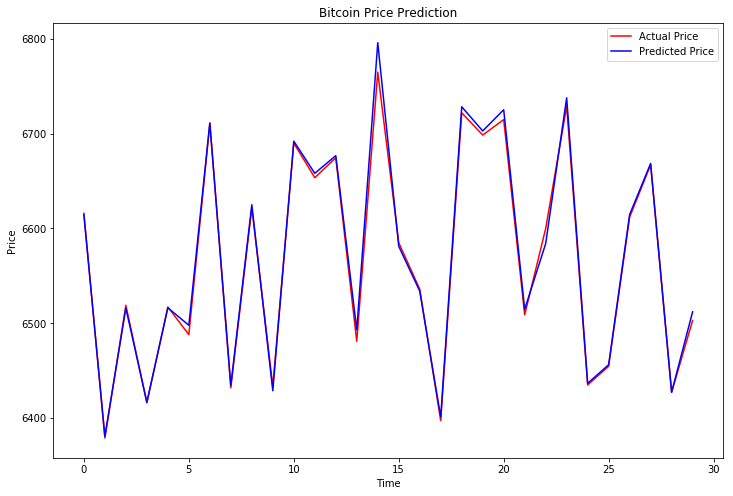

In [8]:
plt.figure(figsize=(12,8))
plt.plot(sc.inverse_transform(validation_y[-30:]), color='red', label="Actual Price")
plt.plot(sc.inverse_transform(model.predict(validation_x[-30:])), color="blue", label="Predicted Price")
plt.title("Bitcoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()